----------
**The Hidden Truth behind Employee Leave**
=====================================

***Zoe Li***

*Aug 2018*

----------

## The Problem

Why are you looking for a change? This is a question frequently asked by recruiters during an interview.

An interviewer would expect 'correct' answers: they enjoy their job, there is nothing they dislike about their current positions, and they are leaving for the right reasons - a better opportunity, more challenges, and career growth.

However, how many facts can be reflected by the sophiscated text-verison answers? For example, if a company is suffering from employee leave, should the company listen to 'words' of their employee or the 'fact' behind data?

Below, we will try to figure out why employee leave for other jobs and come up with suggestions for employers to keep staff.


I take advantage of a dataset from Kaggle.

- satisfaction level 
- last evaluation
- number of projects
- average working hours (per month)
- time spend at company
- work accident
- if promoted in last 5 years
- Department
- salary level (low, medium, high)
- employee left or not


The structure of the project: In Section 2, I inspect data and do feature engineer. In Section 3, I train and evaluate different classfication  models with cross validations. The main conclusions and insights are summarized in Section 4.

-------------------




In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## The Data

In [52]:
data = pd.read_csv("./input/HR_comma_sep.csv")
data.head()
#data.columns

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [34]:
data.info()
#data.left = data.left.astype(int)
#print(data.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


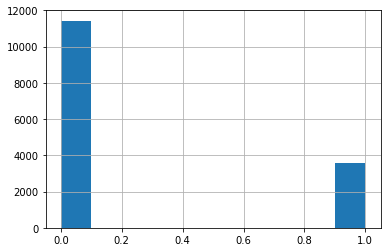

In [36]:
data['left'].hist()

### numerical variables 

(satisfaction level, last evaluation, average monthly hours, time spend company)

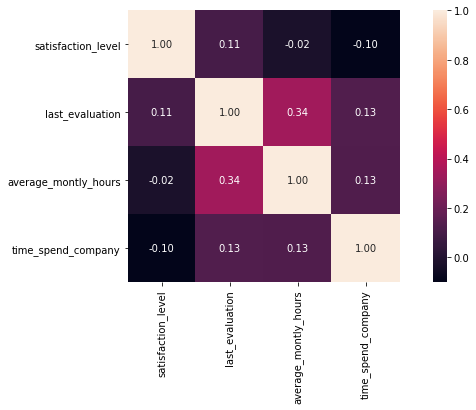

In [45]:
plt.subplots(figsize=(12, 5))
sns.heatmap(data[['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']].corr(), fmt='.2f', annot=True, square=True)

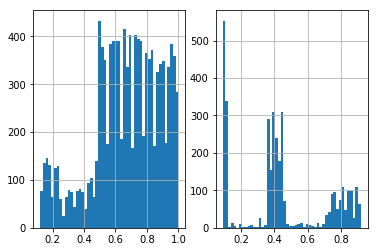

In [40]:
plt.subplot(121)
data[data['left'] == 0]['satisfaction_level'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['satisfaction_level'].hist(bins = 50);

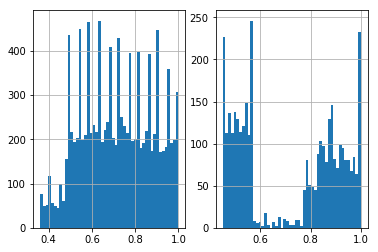

In [39]:
plt.subplot(121)
data[data['left'] == 0]['last_evaluation'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['last_evaluation'].hist(bins = 50);

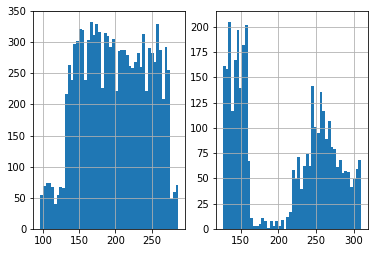

In [41]:
plt.subplot(121)
data[data['left'] == 0]['average_montly_hours'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['average_montly_hours'].hist(bins = 50);

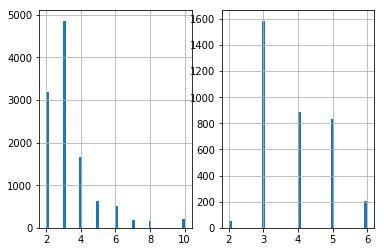

In [43]:
plt.subplot(121)
data[data['left'] == 0]['time_spend_company'].hist(bins = 50)
plt.subplot(122)
data[data['left'] == 1]['time_spend_company'].hist(bins = 50);

### categorical variables
(work accident, promotion, department, number of projects, salary)

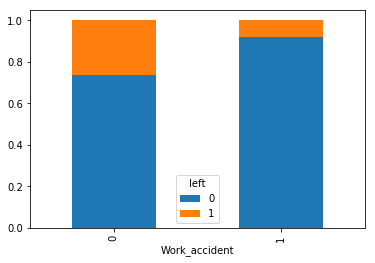

In [49]:
tmp_acc = pd.crosstab(data['Work_accident'], data.left)
tmp_acc.div(tmp_acc.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

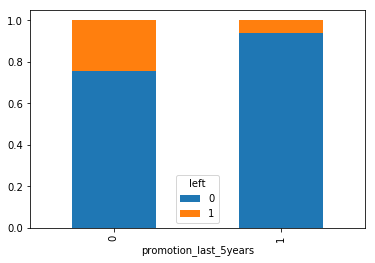

In [50]:
tmp_pro = pd.crosstab(data['promotion_last_5years'], data.left)
tmp_pro.div(tmp_pro.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

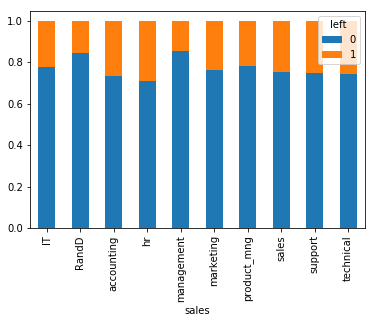

In [53]:
tmp_sales = pd.crosstab(data['sales'], data.left)
tmp_sales.div(tmp_sales.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

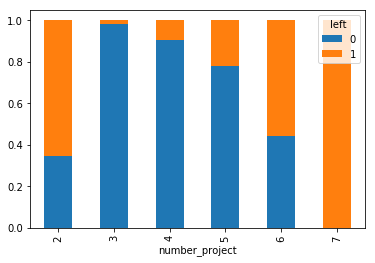

In [54]:
tmp_proj = pd.crosstab(data['number_project'], data.left)
tmp_proj.div(tmp_proj.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

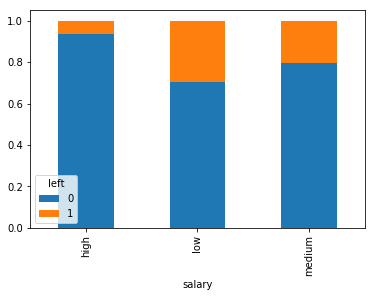

In [55]:
tmp = pd.crosstab(data.salary, data.left)
tmp.div(tmp.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

In [58]:
# tmp_time = pd.crosstab(data['time_spend_company'], data.left)
# tmp_time.div(tmp_time.sum(axis =1), axis = 0).plot(kind = 'bar', stacked = True);

### Dummy variables

In [59]:
from patsy import dmatrices 


y, X = dmatrices('left ~ satisfaction_level + last_evaluation + number_project + average_montly_hours + time_spend_company + Work_accident + promotion_last_5years + C(sales) + C(salary)',data, return_type = 'dataframe')

In [60]:
X = X.rename(columns = {
    'C(sales)[T.RandD]': 'Department: Random',
    'C(sales)[T.accounting]': 'Department: Accounting',
    'C(sales)[T.hr]': 'Department: HR',
    'C(sales)[T.management]': 'Department: Management',
    'C(sales)[T.marketing]': 'Department: Marketing',
    'C(sales)[T.product_mng]': 'Department: Product_Management',
    'C(sales)[T.sales]': 'Department: Sales',
    'C(sales)[T.support]': 'Department: Support',
    'C(sales)[T.technical]': 'Department: Technical',
    'C(salary)[T.low]': 'Salary: Low',
    'C(salary)[T.medium]': 'Salary: Medium'}) 
y = np.ravel(y) 

In [63]:
from sklearn import metrics 
from sklearn.model_selection import  KFold, train_test_split, cross_val_score 


def model_score(model):
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    m_score = cross_val_score(model, X, y, scoring="accuracy", cv=kf)
    return (m_score.mean())

#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Classifications

In [80]:

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.neural_network import MLPClassifier as MLP

model_list = [LR(),KN(),DT(),RF(),GB(),MLP()]


score_l = []
for model in model_list:
    score_l.append(model_score(model))
    
d={'Model':model_list,'Score':score_l}   
res_frame=pd.DataFrame(d)
res_frame



,Model,Score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.789586
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.937863
2,"DecisionTreeClassifier(class_weight=None, crit...",0.977798
3,"RandomForestClassifier(bootstrap=True, class_w...",0.987266
4,GradientBoostingClassifier(criterion='friedman...,0.975065
5,"MLPClassifier(activation='relu', alpha=0.0001,...",0.900793


### LogisticRegression

In [81]:
model = LogisticRegression()
model.fit(X,y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_)))).head()

,0,1
0,Intercept,[-0.7241218101303709]
1,Department: Random,[-0.4646533540507806]
2,Department: Accounting,[0.11480746995707178]
3,Department: HR,[0.34470249740075476]
4,Department: Management,[-0.36197691576765323]


In [82]:
# print(model.score(X,y))
# model.coef_

Predict if one employee will leave: (e.g. high salary HR, satisfaction level 0.5, evalution last time 0.7, 4 projects, 160hr/month, 3 years, no promotion in last 5 years, no injury)

In [19]:
model.predict_proba([[1,0,0,1,0,0,0,0,0,0,0,0, 0.5, 0.7, 4.0, 160, 3.0, 0, 0]])

array([[0.9157868, 0.0842132]])

In [20]:
model.predict_proba(X)
pred = model.predict(X)
(abs(pred-y)).sum() / len(y)

0.20808053870258017

Split dataset into training and testing data

In [22]:
model2 = LogisticRegression(C=10000)
model2.fit(Xtrain, ytrain)
pred = model2.predict(Xtest)
metrics.accuracy_score(ytest, pred)


0.7917777777777778

Get the confusion matrix

In [23]:
metrics.confusion_matrix(ytest, pred)

array([[3199,  263],
       [ 674,  364]])

In [24]:
print(metrics.classification_report(ytest, pred))

             precision    recall  f1-score   support

        0.0       0.83      0.92      0.87      3462
        1.0       0.58      0.35      0.44      1038

avg / total       0.77      0.79      0.77      4500



10 fold Cross Validation